## Import the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
sns.set()

In [40]:
body_building = pd.read_csv('../data/raw_dataset/workout.csv')
fitness = pd.read_csv('../data/raw_dataset/fitness_exercises.csv')
plans = pd.read_csv('../data/raw_dataset/plans.csv')

In [109]:
plans.shape
plans.columns

,goal,level,gender,Equipment Required,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7
0,Gain Muscle,Intermediate,Male & Female,"Bodyweight, Dumbbells","chest, chest, upper arms, upper arms, shoulder...","upper legs, upper legs, lower legs, upper legs...","back, back, chest, back, upper arms, upper arm...","upper legs, back, upper legs, -, lower arms, u...","back, shoulders, chest, back, upper arms, uppe...","chest, chest, upper arms, upper arms, shoulder...","upper legs, upper legs, lower legs, upper legs..."
1,Gain Muscle,Intermediate,Male & Female,"Barbell, Bodyweight, Dumbbells, Machines","upper legs, lower legs, back, back, back, back...","chest, chest, chest, chest, chest, upper arms,...","upper legs, upper legs, upper legs, upper legs...","shoulders, shoulders, shoulders, -, back, back...","upper legs, lower legs, back, back, back, back...","chest, chest, chest, chest, chest, upper arms,...","upper legs, upper legs, upper legs, upper legs..."
2,Gain Muscle,Advanced,Male,"Barbell, Bodyweight, Dumbbells, Machines","chest, chest, chest, chest, chest, upper arms,...","upper legs, lower legs, back, back, back, back...","shoulders, shoulders, shoulders, shoulders, ba...","upper legs, upper legs, upper legs, lower legs...","chest, chest, chest, chest, chest, upper arms,...","upper legs, lower legs, back, back, back, back...","shoulders, shoulders, shoulders, shoulders, ba..."
3,Lose Weight,Beginner,Male & Female,"Barbell, Bodyweight, Cables, Dumbbells, Kettle...","chest, back, shoulders, back, upper arms, uppe...","upper legs, upper legs, lower legs, upper legs...","chest, back, shoulders, back, upper arms, uppe...","upper legs, upper legs, lower legs, upper legs...","chest, back, shoulders, back, upper arms, uppe...","upper legs, upper legs, lower legs, upper legs...","chest, back, shoulders, back, upper arms, uppe..."
4,Gain Muscle,Intermediate,Male & Female,"Barbell, Dumbbells, Machines","chest, chest, back, back, shoulders, upper arm...","upper legs, upper legs, lower legs, upper legs...","chest, chest, back, back, shoulders, upper arm...","upper legs, upper legs, upper legs, upper legs...","chest, chest, back, back, shoulders, upper arm...","upper legs, upper legs, lower legs, upper legs...","chest, chest, back, back, shoulders, upper arm..."
...,...,...,...,...,...,...,...,...,...,...,...
503,Gain Muscle,Beginner,Male & Female,"Barbell, Bodyweight, Cables, Dumbbells","-, upper legs, lower legs, back, back, back","-, -, back, back, back","-, -, back, back, back","-, upper legs, lower legs, back, back, back","-, -, back, back, back","-, -, back, back, back","-, upper legs, lower legs, back, back, back"
504,Gain Muscle,Intermediate,Male & Female,"Barbell, Dumbbells","shoulders, shoulders","upper arms, upper arms, upper arms, upper arms","shoulders, shoulders","shoulders, shoulders","upper arms, upper arms, upper arms, upper arms","shoulders, shoulders","shoulders, shoulders"
505,Lose Weight,Intermediate,Male & Female,"Barbell, Bodyweight, Cables, Dumbbells, EZ Bar...","shoulders, back, back, back, upper arms, upper...","upper legs, upper legs, upper legs, lower legs...","chest, shoulders, shoulders, back, shoulders, ...","upper legs, upper legs, upper legs, upper legs...","shoulders, back, back, back, upper arms, upper...","upper legs, upper legs, upper legs, lower legs...","chest, shoulders, shoulders, back, shoulders, ..."
506,Gain Muscle,Beginner,Male & Female,"Barbell, Cables, Dumbbells, Machines","chest, chest, upper arms, upper arms, shoulder...","upper legs, upper legs, upper legs, upper legs...","chest, back, back, upper arms, upper arms, upp...","chest, chest, upper arms, upper arms, shoulder...","upper legs, upper legs, upper legs, upper legs...","chest, back, back, upper arms, upper arms, upp...","chest, chest, upper arms, upper arms, shoulder..."


In [4]:
plans['Day 4 Body Parts'].fillna(plans['Day 1 Body Parts'], inplace=True)
plans['Day 5 Body Parts'].fillna(plans['Day 2 Body Parts'], inplace=True)
plans['Day 6 Body Parts'].fillna(plans['Day 3 Body Parts'], inplace=True)
plans['Day 7 Body Parts'].fillna(plans['Day 4 Body Parts'], inplace=True)
plans.isna().sum()

KeyError: 'Day 4 Body Parts'

In [5]:
plans.rename(columns={'Day 1 Body Parts':'Day 1','Day 2 Body Parts':'Day 2','Day 3 Body Parts':'Day 3','Day 4 Body Parts':'Day 4','Day 5 Body Parts':'Day 5','Day 6 Body Parts':'Day 6','Day 7 Body Parts':'Day 7'},inplace = True)
print(plans)
plans.columns

             goal         level         gender  \
0     Gain Muscle  Intermediate  Male & Female   
1     Gain Muscle  Intermediate  Male & Female   
2     Gain Muscle      Advanced           Male   
3     Lose Weight      Beginner  Male & Female   
4     Gain Muscle  Intermediate  Male & Female   
..            ...           ...            ...   
503   Gain Muscle      Beginner  Male & Female   
504   Gain Muscle  Intermediate  Male & Female   
505   Lose Weight  Intermediate  Male & Female   
506   Gain Muscle      Beginner  Male & Female   
507   Gain Muscle  Intermediate           Male   

                                    Equipment Required  \
0                                Bodyweight, Dumbbells   
1             Barbell, Bodyweight, Dumbbells, Machines   
2             Barbell, Bodyweight, Dumbbells, Machines   
3    Barbell, Bodyweight, Cables, Dumbbells, Kettle...   
4                         Barbell, Dumbbells, Machines   
..                                                 

Index(['goal', 'level', 'gender', 'Equipment Required', 'Day 1', 'Day 2',
       'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7'],
      dtype='object')

In [113]:
# Define the global variable for the plan classifier
plan_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_cols = []

def train_model(data):
    global plan_classifier
    global X_train_cols
    # One-hot encode categorical variables
    data_encoded = pd.get_dummies(data, columns=['level', 'goal', 'gender'])
    male_female_rows = data_encoded['gender_Male & Female'] == 1

    # Set 'gender_Male' and 'gender_Female' to True for these rows
    data_encoded.loc[male_female_rows, 'gender_Male'] = 1
    data_encoded.loc[male_female_rows, 'gender_Female'] = 1

    print(data_encoded)
    # Assuming you have a DataFrame 'data' containing input variables and 'plan' as the label
    X = data_encoded.drop(columns=['Equipment Required','Day 1', 'Day 2', 'Day 3','Day 4', 'Day 5', 'Day 6', 'Day 7'])
    days_list = data_encoded[['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7']].values.tolist()
    y = days_list


    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_cols = X_train.columns

    # Train the Random Forest Classifier
    plan_classifier.fit(X_train, y_train)

    with open('plan_classifier.pickle', 'wb') as f:
      pickle.dump(plan_classifier, f)
    # Evaluate the model
    y_pred = plan_classifier.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    # print("Model Accuracy:", accuracy)


train_model(plans)


                                    Equipment Required  \
0                                Bodyweight, Dumbbells   
1             Barbell, Bodyweight, Dumbbells, Machines   
2             Barbell, Bodyweight, Dumbbells, Machines   
3    Barbell, Bodyweight, Cables, Dumbbells, Kettle...   
4                         Barbell, Dumbbells, Machines   
..                                                 ...   
503             Barbell, Bodyweight, Cables, Dumbbells   
504                                 Barbell, Dumbbells   
505  Barbell, Bodyweight, Cables, Dumbbells, EZ Bar...   
506               Barbell, Cables, Dumbbells, Machines   
507                     Barbell, Bodyweight, Dumbbells   

                                                 Day 1  \
0    chest, chest, upper arms, upper arms, shoulder...   
1    upper legs, lower legs, back, back, back, back...   
2    chest, chest, chest, chest, chest, upper arms,...   
3    chest, back, shoulders, back, upper arms, uppe...   
4    chest, c

In [43]:
body_building.columns

Index(['Unnamed: 0', 'Title', 'Desc', 'Type', 'BodyPart', 'Equipment', 'Level',
       'Rating', 'RatingDesc'],
      dtype='object')

In [44]:
body_building.shape

(2915, 9)

In [45]:
body_building.isna().sum()

Unnamed: 0       0
Title            0
Desc          1547
Type             0
BodyPart         0
Equipment        0
Level            0
Rating        1887
RatingDesc    2056
dtype: int64

In [46]:
body_building = body_building.drop(['Unnamed: 0','Desc','Rating','RatingDesc'],axis=1)

In [47]:
body_building.describe(include='all')

,Title,Type,BodyPart,Equipment,Level
count,2915,2915,2915,2915,2915
unique,2906,7,17,12,3
top,Band-suspended kettlebell bench press,Strength,Abdominals,Body Only,Intermediate
freq,3,2545,662,1100,2446


In [48]:
exercises = body_building['Title'].value_counts()
exercises

Title
Band-suspended kettlebell bench press    3
Seated Cable Rows                        3
Seated rear delt fly                     2
Decline bar press sit-up                 2
Arnold press                             2
                                        ..
Plyo push-up                             1
Close-grip hands-elevated push-up        1
Suspended push-up                        1
Push Up to Side Plank                    1
30 Arms EZ-Bar Skullcrusher              1
Name: count, Length: 2906, dtype: int64

In [49]:
body_building.drop_duplicates(subset='Title',keep='first', inplace = True)
body_building['Title'].value_counts()

Title
Partner plank band row                             1
Dumbbell Fix Dumbbell Split Squat                  1
Dumbbell Fix Dumbbell Alternating Reverse Lunge    1
Dumbbell Fix Turkish Get-Up                        1
Seesaw lunge                                       1
                                                  ..
Close-Hands Push-Up                                1
Tiger-bend push-up                                 1
Plyo push-up                                       1
Close-grip hands-elevated push-up                  1
30 Arms EZ-Bar Skullcrusher                        1
Name: count, Length: 2906, dtype: int64

<Axes: xlabel='BodyPart'>

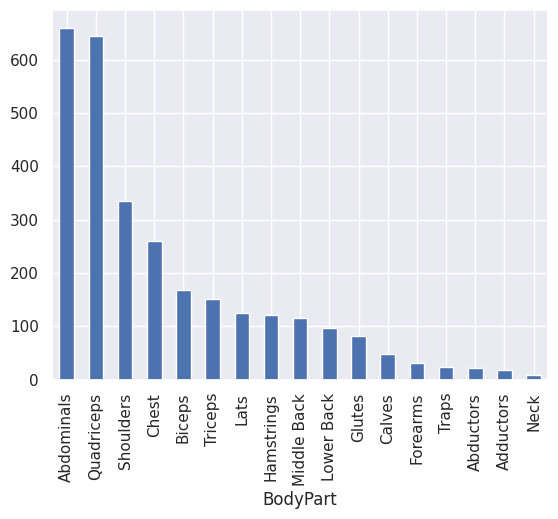

In [50]:
body_building['BodyPart'].value_counts().plot.bar()

In [51]:
body_building['Equipment'].unique()

array(['Bands', 'Barbell', 'Kettlebells', 'Dumbbell', 'Other', 'Cable',
       'Machine', 'Body Only', 'Medicine Ball', 'Exercise Ball',
       'Foam Roll', 'E-Z Curl Bar'], dtype=object)

<Axes: xlabel='Equipment'>

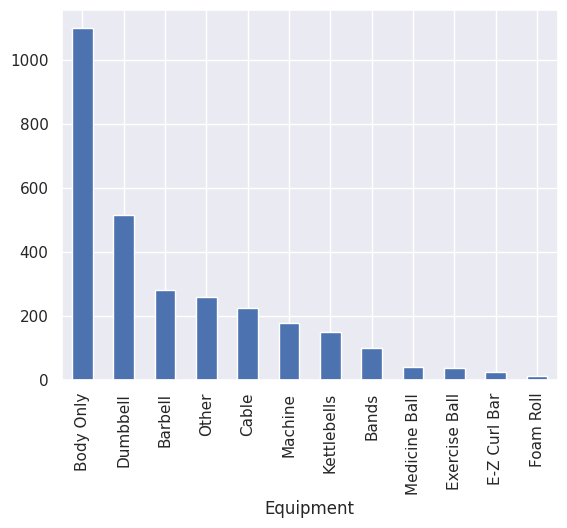

In [52]:
body_building['Equipment'].value_counts().plot.bar()

In [53]:
body_building['Level'].value_counts()

Level
Intermediate    2437
Beginner         456
Expert            13
Name: count, dtype: int64

<Axes: xlabel='Type'>

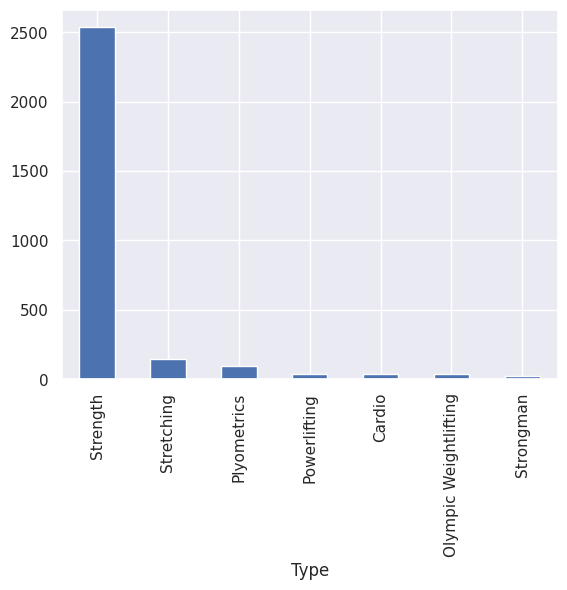

In [54]:
body_building['Type'].value_counts().plot.bar()

In [55]:
body_building['gym']= 1
body_building['home']=body_building['Equipment'].map({'Body Only':1,'Bands':1, 'Barbell':0, 'Kettlebells':0, 'Dumbbell':1, 'Other':0, 'Cable':0,'Machine':0,'Medicine Ball':0, 'Exercise Ball':1,'Foam Roll':1, 'E-Z Curl Bar':0})
body_building['goal']='Gain Muscle'
body_building

,Title,Type,BodyPart,Equipment,Level,gym,home,goal
0,Partner plank band row,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle
1,Banded crunch isometric hold,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle
2,FYR Banded Plank Jack,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle
3,Banded crunch,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle
4,Crunch,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle
...,...,...,...,...,...,...,...,...
2910,EZ-bar skullcrusher-,Strength,Triceps,E-Z Curl Bar,Intermediate,1,0,Gain Muscle
2911,Lying Close-Grip Barbell Triceps Press To Chin,Strength,Triceps,E-Z Curl Bar,Beginner,1,0,Gain Muscle
2912,EZ-Bar Skullcrusher - Gethin Variation,Strength,Triceps,E-Z Curl Bar,Intermediate,1,0,Gain Muscle
2913,TBS Skullcrusher,Strength,Triceps,E-Z Curl Bar,Intermediate,1,0,Gain Muscle


In [56]:
body_building =body_building.reset_index(drop = True)


In [57]:
fitness.columns

Index(['bodyPart', 'equipment', 'gifUrl', 'id', 'name', 'target', 'Level'], dtype='object')

In [58]:
fitness.shape

(1327, 7)

In [59]:
fitness.isna().sum()

bodyPart     0
equipment    0
gifUrl       0
id           0
name         0
target       0
Level        0
dtype: int64

In [60]:
fitness.describe(include='all')

,bodyPart,equipment,gifUrl,id,name,target,Level
count,1327,1327,1327,1327.000000,1327,1327,1327
unique,10,28,1327,NaN,1322,19,3
top,upper arms,body weight,http://d205bpvrqc9yn1.cloudfront.net/0001.gif,NaN,self assisted inverse leg curl,abs,Intermediate
freq,292,325,1,NaN,2,170,857
mean,NaN,NaN,NaN,1189.528259,NaN,NaN,NaN
std,NaN,NaN,NaN,1006.661464,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,378.500000,NaN,NaN,NaN
50%,NaN,NaN,NaN,862.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,1661.500000,NaN,NaN,NaN


In [61]:
fitness['name'].value_counts()

name
self assisted inverse leg curl    2
smith reverse calf raises         2
ez barbell spider curl            2
barbell seated calf raise         2
push-up (on stability ball)       2
                                 ..
close-grip push-up                1
close grip chin-up                1
clock push-up                     1
clap push up                      1
wrist rollerer                    1
Name: count, Length: 1322, dtype: int64

In [62]:
fitness.drop_duplicates(subset='name',keep='first', inplace = True)
fitness['name'].value_counts()

name
3/4 sit-up                                          1
kettlebell hang clean                               1
kettlebell front squat                              1
kettlebell figure 8                                 1
kettlebell extended range one arm press on floor    1
                                                   ..
close grip chin-up                                  1
clock push-up                                       1
clap push up                                        1
circles knee stretch                                1
wrist rollerer                                      1
Name: count, Length: 1322, dtype: int64

In [27]:
fitness['bodyPart'].value_counts()

bodyPart
upper arms    291
upper legs    226
back          203
waist         170
chest         163
shoulders     144
lower legs     57
lower arms     37
cardio         29
neck            2
Name: count, dtype: int64

<Axes: xlabel='bodyPart'>

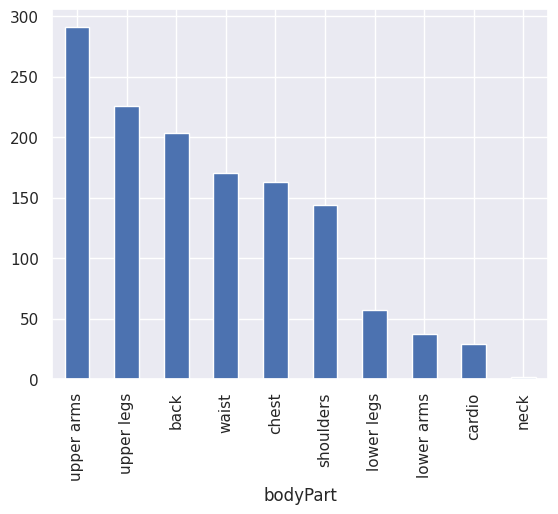

In [63]:
fitness['bodyPart'].value_counts().plot.bar()

<Axes: xlabel='target'>

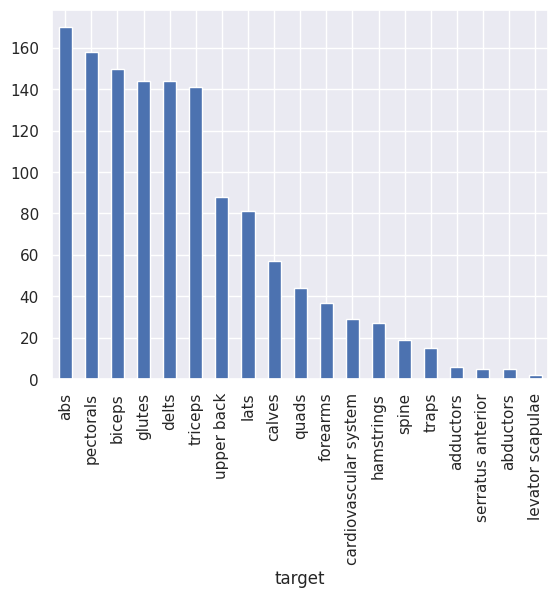

In [64]:
fitness['target'].value_counts().plot.bar()

In [65]:
fitness['equipment'].unique()

array(['body weight', 'cable', 'leverage machine', 'assisted',
       'medicine ball', 'stability ball', 'band', 'barbell', 'rope',
       'dumbbell', 'ez barbell', 'sled machine', 'upper body ergometer',
       'kettlebell', 'olympic barbell', 'weighted', 'bosu ball',
       'resistance band', 'roller', 'skierg machine', 'hammer',
       'smith machine', 'wheel roller', 'stationary bike', 'tire',
       'trap bar', 'elliptical machine', 'stepmill machine'], dtype=object)

<Axes: xlabel='equipment'>

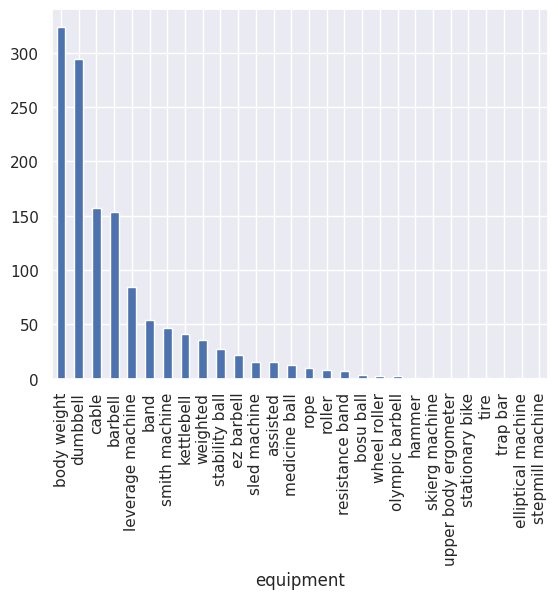

In [66]:
fitness['equipment'].value_counts().plot.bar()

In [67]:
fitness['gym']=1
fitness['home']=fitness['equipment'].map({'body weight':1, 'cable':0, 'leverage machine':0, 'assisted':0,'medicine ball':0, 'stability ball':1, 'band':1, 'barbell':0, 'rope':0 ,'dumbbell':1, 'ez barbell':0, 'sled machine':0, 'upper body ergometer':0, 'kettlebell':0, 'olympic barbell':0, 'weighted':0, 'bosu ball':1, 'resistance band':1, 'roller':1, 'skierg machine':0, 'hammer':0,'smith machine':0, 'wheel roller':1, 'stationary bike':0, 'tire':0,'trap bar':0, 'elliptical machine':0, 'stepmill machine':0})
fitness['goal']='Get Fitter & Lose Weight'
fitness

,bodyPart,equipment,gifUrl,id,name,target,Level,gym,home,goal
0,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0001.gif,1,3/4 sit-up,abs,Beginner,1,1,Get Fitter & Lose Weight
1,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0002.gif,2,45° side bend,abs,Beginner,1,1,Get Fitter & Lose Weight
2,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0003.gif,3,air bike,abs,Beginner,1,1,Get Fitter & Lose Weight
3,upper legs,body weight,http://d205bpvrqc9yn1.cloudfront.net/1512.gif,1512,all fours squad stretch,quads,Beginner,1,1,Get Fitter & Lose Weight
4,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0006.gif,6,alternate heel touchers,abs,Beginner,1,1,Get Fitter & Lose Weight
...,...,...,...,...,...,...,...,...,...,...
1322,chest,body weight,http://d205bpvrqc9yn1.cloudfront.net/2363.gif,2363,wide-grip chest dip on high parallel bars,pectorals,Beginner,1,1,Get Fitter & Lose Weight
1323,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0858.gif,858,wind sprints,abs,Beginner,1,1,Get Fitter & Lose Weight
1324,upper legs,body weight,http://d205bpvrqc9yn1.cloudfront.net/1604.gif,1604,world greatest stretch,hamstrings,Beginner,1,1,Get Fitter & Lose Weight
1325,lower arms,body weight,http://d205bpvrqc9yn1.cloudfront.net/1428.gif,1428,wrist circles,forearms,Beginner,1,1,Get Fitter & Lose Weight


In [68]:
fitness =fitness.reset_index(drop = True)

In [69]:
body_building.rename(columns={'BodyPart':'target','Title':'name','Equipment':'equipment'},inplace = True)
body_building.columns

Index(['name', 'Type', 'target', 'equipment', 'Level', 'gym', 'home', 'goal'], dtype='object')

In [70]:
body_building['target'].unique()

array(['Abdominals', 'Adductors', 'Abductors', 'Biceps', 'Calves',
       'Chest', 'Forearms', 'Glutes', 'Hamstrings', 'Lats', 'Lower Back',
       'Middle Back', 'Traps', 'Neck', 'Quadriceps', 'Shoulders',
       'Triceps'], dtype=object)

In [71]:
body_building['bodyPart']= body_building['target'].map({'Abdominals':'waist', 'Adductors':'upper legs', 'Abductors':'upper legs', 'Biceps':'upper arms', 'Calves':'lower legs', 'Chest':'chest',
       'Forearms':'lower arms', 'Glutes':'upper legs', 'Hamstrings':'upper legs', 'Lats':'back', 'Lower Back':'back',
       'Middle Back':'back', 'Traps':'back', 'Neck':'neck', 'Quadriceps':'upper legs','Shoulders':'shoulders', 'Triceps':'upper arms'})


In [72]:
data = pd.merge(body_building,fitness ,on=['name','target', 'equipment', 'Level','gym', 'home', 'goal','bodyPart'],how='outer')
data

,name,Type,target,equipment,Level,gym,home,goal,bodyPart,gifUrl,id
0,Partner plank band row,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle,waist,NaN,NaN
1,Banded crunch isometric hold,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle,waist,NaN,NaN
2,FYR Banded Plank Jack,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle,waist,NaN,NaN
3,Banded crunch,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle,waist,NaN,NaN
4,Crunch,Strength,Abdominals,Bands,Intermediate,1,1,Gain Muscle,waist,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4223,wide-grip chest dip on high parallel bars,NaN,pectorals,body weight,Beginner,1,1,Get Fitter & Lose Weight,chest,http://d205bpvrqc9yn1.cloudfront.net/2363.gif,2363.0
4224,wind sprints,NaN,abs,body weight,Beginner,1,1,Get Fitter & Lose Weight,waist,http://d205bpvrqc9yn1.cloudfront.net/0858.gif,858.0
4225,world greatest stretch,NaN,hamstrings,body weight,Beginner,1,1,Get Fitter & Lose Weight,upper legs,http://d205bpvrqc9yn1.cloudfront.net/1604.gif,1604.0
4226,wrist circles,NaN,forearms,body weight,Beginner,1,1,Get Fitter & Lose Weight,lower arms,http://d205bpvrqc9yn1.cloudfront.net/1428.gif,1428.0


In [73]:
data['bodyPart'].unique()

array(['waist', 'upper legs', 'upper arms', 'lower legs', 'chest',
       'lower arms', 'back', 'neck', 'shoulders', 'cardio'], dtype=object)

In [74]:
data.isna().sum()

name            0
Type         1322
target          0
equipment       0
Level           0
gym             0
home            0
goal            0
bodyPart        0
gifUrl       2906
id           2906
dtype: int64

In [75]:
data.replace(to_replace = ['Body Only','Bands','resistance band','Dumbbell','Barbell','Cable','Medicine Ball','Other','E-Z Curl Bar','stability ball','roller','Kettlebells'],value=['body weight','band', 'band','dumbbell','barbell','cable','medicine ball','weighted','ez barbell','Exercise Ball','Foam Roll','kettlebell'],inplace= True)

In [76]:
data['equipment'].unique()

array(['band', 'barbell', 'kettlebell', 'dumbbell', 'weighted', 'cable',
       'Machine', 'body weight', 'medicine ball', 'Exercise Ball',
       'Foam Roll', 'ez barbell', 'leverage machine', 'assisted', 'rope',
       'sled machine', 'upper body ergometer', 'olympic barbell',
       'bosu ball', 'skierg machine', 'hammer', 'smith machine',
       'wheel roller', 'stationary bike', 'tire', 'trap bar',
       'elliptical machine', 'stepmill machine'], dtype=object)

In [ ]:
data['type']=data['equipment'].map({'band':'duration', 'barbell':'weight',  'dumbbell':'weight', 'cable':'weight',
       'Machine':'weight', 'body weight':'duration', 'medicine ball':'weight', 'Exercise Ball':'duration',
       'Foam Roll':'duration', 'leverage machine':'weight', 'assisted':'weight',
        'rope':'weight', 'ez barbell':'weight', 'sled machine':'weight',
       'upper body ergometer':'duration', 'kettlebell':'weight', 'olympic barbell':'weight',
       'weighted':'weight', 'bosu ball':'duration',
       'skierg machine':'weight', 'hammer':'weight', 'smith machine':'weight', 'wheel roller':'duration',
       'stationary bike':'duration','trap bar':'weight', 'elliptical machine':'duration',
       'stepmill machine':'duration'})

In [77]:
data.replace(to_replace = 'Expert',value='Advanced',inplace = True)

In [78]:
print(len(data['name'].unique()))

4227


In [79]:
data.shape

(4228, 11)

In [80]:
data['name'].value_counts()

name
3/4 sit-up                                   2
Partner plank band row                       1
Suspended Triceps Press                      1
Reverse Grip Triceps Pushdown                1
Cable V-bar push-down                        1
                                            ..
Barbell pull-over to press                   1
Single-arm barbell bent-over row             1
Reverse Barbell Row                          1
Side kick-through to kettlebell high pull    1
wrist rollerer                               1
Name: count, Length: 4227, dtype: int64

In [81]:
fitness.drop_duplicates(subset='name',keep='first', inplace = True)
data=data.drop("gifUrl",axis=1)
data=data.drop("id",axis=1)
data=data.drop("Type",axis=1)

data

,name,target,equipment,Level,gym,home,goal,bodyPart
0,Partner plank band row,Abdominals,band,Intermediate,1,1,Gain Muscle,waist
1,Banded crunch isometric hold,Abdominals,band,Intermediate,1,1,Gain Muscle,waist
2,FYR Banded Plank Jack,Abdominals,band,Intermediate,1,1,Gain Muscle,waist
3,Banded crunch,Abdominals,band,Intermediate,1,1,Gain Muscle,waist
4,Crunch,Abdominals,band,Intermediate,1,1,Gain Muscle,waist
...,...,...,...,...,...,...,...,...
4223,wide-grip chest dip on high parallel bars,pectorals,body weight,Beginner,1,1,Get Fitter & Lose Weight,chest
4224,wind sprints,abs,body weight,Beginner,1,1,Get Fitter & Lose Weight,waist
4225,world greatest stretch,hamstrings,body weight,Beginner,1,1,Get Fitter & Lose Weight,upper legs
4226,wrist circles,forearms,body weight,Beginner,1,1,Get Fitter & Lose Weight,lower arms


In [82]:
data['target'].replace(to_replace = ['Abdominals','Lats','Triceps','Traps','Calves','Glutes','Biceps','Hamstrings','Shoulders','Forearms','Adductors', 'Abductors','Quadriceps','Chest','Neck'],value=['abs','lats','triceps','traps','calves','glutes','biceps','hamstrings','delts','forearms','adductors','abductors','quads','pectorals','levator scapulae'],inplace= True)

In [83]:
data['bodyPart'].unique()

array(['waist', 'upper legs', 'upper arms', 'lower legs', 'chest',
       'lower arms', 'back', 'neck', 'shoulders', 'cardio'], dtype=object)

In [84]:
data['target'].unique()

array(['abs', 'adductors', 'abductors', 'biceps', 'calves', 'pectorals',
       'forearms', 'glutes', 'hamstrings', 'lats', 'Lower Back',
       'Middle Back', 'traps', 'levator scapulae', 'quads', 'delts',
       'triceps', 'cardiovascular system', 'spine', 'upper back',
       'serratus anterior'], dtype=object)

<Axes: xlabel='equipment'>

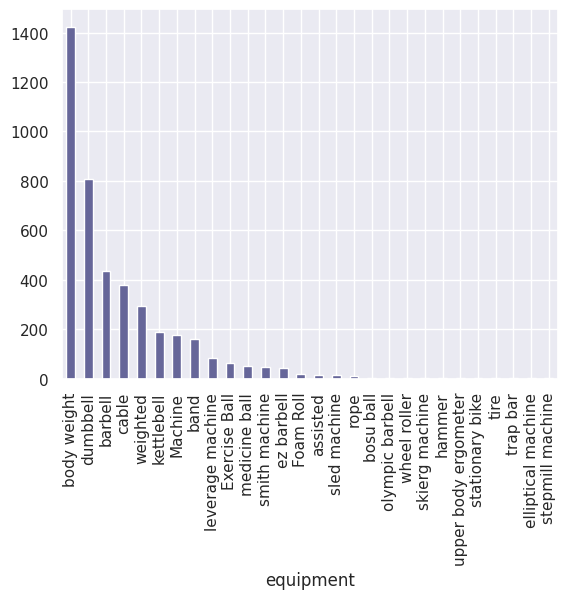

In [85]:
c=(0.4,.4,0.6)
data['equipment'].value_counts().plot.bar(color=c  )

<Axes: xlabel='target'>

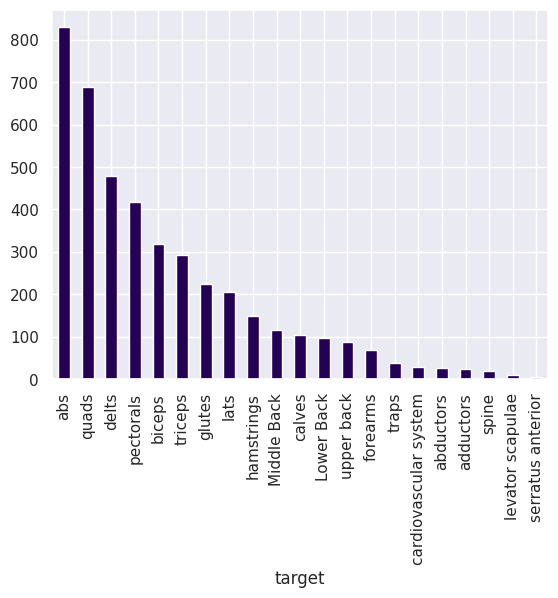

In [ ]:
c='#240155'
data['target'].value_counts().plot.bar(color=c)

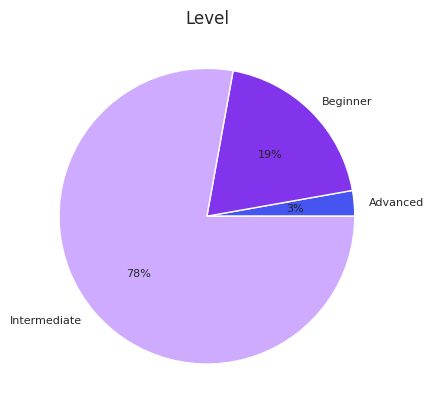

In [86]:
colors=[ '#4654f0', '#8134ec','#CEABFF']
#data['Level'].value_counts().plot.pie(colors=colors)
data.Level.str.get_dummies().sum().plot(kind='pie', title='Level', autopct='%1.0f%%',colors=colors,fontsize =8 );

In [87]:
data['equipment'].value_counts()

equipment
body weight             1424
dumbbell                 808
barbell                  434
cable                    380
weighted                 293
kettlebell               190
Machine                  177
band                     159
leverage machine          84
Exercise Ball             63
medicine ball             51
smith machine             47
ez barbell                44
Foam Roll                 19
assisted                  15
sled machine              15
rope                      10
bosu ball                  3
olympic barbell            2
wheel roller               2
skierg machine             1
hammer                     1
upper body ergometer       1
stationary bike            1
tire                       1
trap bar                   1
elliptical machine         1
stepmill machine           1
Name: count, dtype: int64

In [88]:
data['Level'].value_counts()

Level
Intermediate    3291
Beginner         819
Advanced         118
Name: count, dtype: int64

In [89]:
num_sets = np.random.randint(3, 6, size=len(data))
data['sets'] = num_sets
data


,name,target,equipment,Level,gym,home,goal,bodyPart,sets
0,Partner plank band row,abs,band,Intermediate,1,1,Gain Muscle,waist,4
1,Banded crunch isometric hold,abs,band,Intermediate,1,1,Gain Muscle,waist,3
2,FYR Banded Plank Jack,abs,band,Intermediate,1,1,Gain Muscle,waist,3
3,Banded crunch,abs,band,Intermediate,1,1,Gain Muscle,waist,5
4,Crunch,abs,band,Intermediate,1,1,Gain Muscle,waist,4
...,...,...,...,...,...,...,...,...,...
4223,wide-grip chest dip on high parallel bars,pectorals,body weight,Beginner,1,1,Get Fitter & Lose Weight,chest,4
4224,wind sprints,abs,body weight,Beginner,1,1,Get Fitter & Lose Weight,waist,5
4225,world greatest stretch,hamstrings,body weight,Beginner,1,1,Get Fitter & Lose Weight,upper legs,4
4226,wrist circles,forearms,body weight,Beginner,1,1,Get Fitter & Lose Weight,lower arms,3


In [90]:
data['target'].value_counts()

target
abs                      830
quads                    689
delts                    479
pectorals                418
biceps                   318
triceps                  292
glutes                   225
lats                     205
hamstrings               148
Middle Back              116
calves                   104
Lower Back                97
upper back                88
forearms                  68
traps                     39
cardiovascular system     29
abductors                 26
adductors                 23
spine                     19
levator scapulae          10
serratus anterior          5
Name: count, dtype: int64

In [91]:
unique_body_parts = data['bodyPart'].unique()

print("Unique values in the 'body part' column:")
for part in unique_body_parts:
    print(part)

Unique values in the 'body part' column:
waist
upper legs
upper arms
lower legs
chest
lower arms
back
neck
shoulders
cardio


In [107]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

# Select relevant features for clustering
features = data[["Level", "goal", "bodyPart"]]

# Perform one-hot encoding for categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(features)

# Choose the number of clusters
n_clusters = 90

# Apply KMeans clustering algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

with open('kmeans.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

clusters = kmeans.fit_predict(encoded_features)

# Add cluster labels to the dataset
data["cluster"] = clusters

# Print the count of exercises in each cluster
print(data["cluster"].value_counts())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training Inertia: 255.61458018518292
Training Silhouette Score: 0.924196882005916
Testing Silhouette Score: 0.9042478833725393
cluster
3     718
5     630
66    301
6     291
0     258
2     236
7     193
11    157
10    131
13    128
9     121
12    113
15     97
1      77
16     67
14     62
18     62
19     61
67     58
20     44
17     43
24     33
22     31
25     31
23     31
26     29
27     28
28     28
21     22
29     18
33     16
32     14
31     13
30     12
34     12
37     11
35     10
36     10
38      7
39      6
40      4
42      3
41      3
44      2
43      2
45      2
46      1
47      1
Name: count, dtype: int64


In [93]:
cluster_data = {}

# Iterate over each cluster label
for cluster_label in range(n_clusters):
    # Filter the dataset to get data for the current cluster
    cluster_subset = data[data["cluster"] == cluster_label]

    # Add the cluster data to the dictionary
    cluster_data[cluster_label] = cluster_subset

In [108]:
import random

def get_daily_recommendation(home_or_gym, level, goal, bodyParts, equipments):
    if goal in ['Lose Weight', 'Get Fitter']:
      goal = "Get Fitter & Lose Weight"
    daily_recommendations = []

    bodyParts = [bp for bp in bodyParts if '-' not in bp]
     # Repeat elements in bodyParts until it reaches a size of 6
    while len(bodyParts) < 6:
        bodyParts += bodyParts

    # Limit bodyParts to size 6
    bodyParts = bodyParts[:6]

    for bodyPart in bodyParts:
        # Predict cluster for the specified combination of goal, level, and body part
        input_data = [[level, goal, bodyPart]]
        predicted_cluster = kmeans.predict(encoder.transform(input_data))[0]
        print(predicted_cluster)
        #Get data for the predicted cluster
        cluster_subset = cluster_data[predicted_cluster]

        # Filter data based on location (home or gym)
        if home_or_gym == 0:
            cluster_subset = cluster_subset[~cluster_subset["equipment"].isin(equipments)]

        # Randomly select one exercise from the cluster if any left after equipment filtering
        if not cluster_subset.empty:
            selected_exercise = random.choice(cluster_subset.to_dict(orient='records'))
            daily_recommendations.append(selected_exercise)

    # Remove duplicates from the list
    unique_recommendations = []
    seen_names = set()
    for exercise in daily_recommendations:
        if exercise['name'] not in seen_names:
            unique_recommendations.append(exercise)
            seen_names.add(exercise['name'])

    return unique_recommendations

# Example usage
home_or_gym = 0
level = "Beginner"
goal = "Get Fitter & Lose Weight"
bodyParts = ["waist", "back", "cardio"]
equipments = ["body weight", "dumbbell"]

recommendations = get_daily_recommendation(home_or_gym, level, goal, bodyParts, equipments)
print("Daily Recommendations:")
for idx, exercise in enumerate(recommendations, start=1):
    print(f"{idx}. {exercise}")


16
4
18
16
4
18
Daily Recommendations:
1. {'name': 'Pass-through stretch with band', 'target': 'pectorals', 'equipment': 'weighted', 'Level': 'Beginner', 'gym': 1, 'home': 0, 'goal': 'Gain Muscle', 'bodyPart': 'chest', 'sets': 3, 'cluster': 16}
2. {'name': 'twin handle parallel grip lat pulldown', 'target': 'lats', 'equipment': 'cable', 'Level': 'Beginner', 'gym': 1, 'home': 0, 'goal': 'Get Fitter & Lose Weight', 'bodyPart': 'back', 'sets': 5, 'cluster': 18}
3. {'name': 'Barbell Bench Press-Wide Grip', 'target': 'pectorals', 'equipment': 'barbell', 'Level': 'Beginner', 'gym': 1, 'home': 0, 'goal': 'Gain Muscle', 'bodyPart': 'chest', 'sets': 3, 'cluster': 16}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHo

In [ ]:
def get_gender_adjustment(gender):
    return 1.0 if gender == 'Male' else 0.7

def get_age_adjustment(age):
    if age < 30:
        return 1.0
    elif 30 <= age < 50:
        return 0.5
    else:
        return 0.1

def get_level_adjustment(level):
    if level == 'Beginner':
        return 0.8
    elif level == 'Intermediate':
        return 1.0
    elif level == 'Advanced':
        return 1.2

def get_body_part_adjustment(body_part):
    body_parts = {
        'chest': 1,
        'shoulders': 0.8,
        'waist': 0.6,
        'upper legs': 0.7,
        'back': 0.9,
        'lower legs': 0.5,
        'upper arms': 0.8,
        'cardio': 0.7,
        'lower arms': 0.6,
        'neck': 0.5
    }
    return body_parts.get(body_part, 0)
def adjust_workout(gender, age, feedback, body_part, level, old_weight):
    gender_adjustment = get_gender_adjustment(gender)
    age_adjustment = get_age_adjustment(age)
    level_adjustment = get_level_adjustment(level)
    body_part_adjustment = get_body_part_adjustment(body_part)

    increasing_factor_of_weight = age_adjustment * body_part_adjustment * gender_adjustment * level_adjustment * 0.3

    if not feedback:
        increasing_factor_of_weight = (1-increasing_factor_of_weight)*-0.1


    new_weight = old_weight + increasing_factor_of_weight * old_weight

    return  new_weight


gender = 'Female'
age = 20
feedback = False
body_part = 'chest'
level = 'Beginner'
old_weight = 20

new_weight = adjust_workout(gender, age, feedback, body_part, level, old_weight)

print("New weight:", new_weight)


New weight: 18.336


In [ ]:
def calculate_new_repetition(level, goal):
    if goal in ['Lose Weight', 'Get Fitter']:
        if level == 'Beginner':
            return 15
        elif level == 'Intermediate':
            return 12
        elif level == 'Expert':
            return 10
    elif goal == 'Gain Muscle':
        if level == 'Beginner':
            return 10
        elif level == 'Intermediate':
            return 8
        elif level == 'Advanced':
            return 6



In [ ]:
def calculate_new_duration(level):

    if level == 'Beginner':
        return 20
    elif level == 'Intermediate':
        return 50
    elif level == 'Advanced':
        return 80


In [ ]:
def model(home_or_gym, level, goal, gender, age, feedback, old_weight, equipments):

    plan = choose_plan(level, goal, gender)
    print(plan)

    while len(plan) < 30:
        plan.extend(plan)
    plan = plan[:30]

    all_recommendations = []
    for day_body_parts in plan:
        daily_exercises = get_daily_recommendation(home_or_gym, level, goal, day_body_parts, equipments)
        daily_recommendations = []

        for exercise in daily_exercises:
            weights = adjust_workout(gender, age, feedback, exercise['bodyPart'], level, old_weight)
            repetitions = calculate_new_repetition(level, goal)
            duration = calculate_new_duration(level)
            weights_or_duration = weights if exercise['type'] == "weight" else duration
            exercise_recommendations = {
                'name': exercise['name'],
                'type': exercise['type'],
                'equipment': exercise['equipment'],
                'bodyPart': exercise['bodyPart'],
                'target': exercise['target'],
                'weights_or_duration': weights_or_duration,
                'sets': exercise['sets'],
                'repetitions': repetitions,
            }
            daily_recommendations.append(exercise_recommendations)
        all_recommendations.append(daily_recommendations)


    return all_recommendations  # Trim to ensure exactly 30 elements


In [ ]:
def choose_plan(level, goal, gender):
    global plan_classifier
    # Convert input into a DataFrame

    input_data = pd.DataFrame({'level': [level], 'goal': [goal], 'gender': [gender]})

    # One-hot encode the input data
    input_encoded = pd.get_dummies(input_data, columns=['level', 'goal', 'gender'])

    # Ensure that input has the same columns as the model was trained on
    # This is necessary in case some categories are missing in the input
    missing_cols = set(X_train_cols) - set(input_encoded.columns)
    for col in missing_cols:
        input_encoded[col] = 0

    # Reorder columns to match the order of columns in X_train
    input_encoded = input_encoded[X_train_cols]

    # Make prediction for the given input using the trained model
    prediction = plan_classifier.predict(input_encoded)


    # Convert each string in the list to a list of strings
    daily_activities_lists = [day.split(', ') for day in prediction[0]]


    return daily_activities_lists


In [ ]:
recommendations = model(1, "Advanced", "Gain Muscle", "Male", 22, True, 5, [])
for day_number, daily_recommendations in enumerate(recommendations, start=1):
    print("Day", day_number, "Recommendations:")
    for recommendation in daily_recommendations:
        print("Exercise Recommendations:")
        for key, value in recommendation.items():
            print(f"{key}: {value}")
        print()

[['shoulders', 'shoulders', 'shoulders', 'shoulders', 'shoulders'], ['back', 'back', 'back', 'back', 'upper legs', 'lower legs'], ['chest', 'chest', 'chest', 'chest'], ['upper legs', '-', 'upper legs', 'upper legs', 'lower legs', 'upper legs', 'lower legs', 'upper legs', 'lower legs'], ['upper arms', 'upper arms', '-', 'upper arms', 'upper arms', 'upper arms', 'upper arms', 'upper arms', 'upper arms', '-'], ['shoulders', 'shoulders', 'shoulders', 'shoulders', 'shoulders'], ['back', 'back', 'back', 'back', 'upper legs', 'lower legs']]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHo

Day 1 Recommendations:
Exercise Recommendations:
name: See-Saw Press (Alternating Side Press)
type: weight
equipment: dumbbell
bodyPart: shoulders
target: delts
weights_or_duration: 6.4399999999999995
sets: 4
repetitions: 6

Exercise Recommendations:
name: Two-Arm Kettlebell Clean
type: weight
equipment: kettlebell
bodyPart: shoulders
target: delts
weights_or_duration: 6.4399999999999995
sets: 5
repetitions: 6

Exercise Recommendations:
name: Cable Internal Rotation
type: weight
equipment: cable
bodyPart: shoulders
target: delts
weights_or_duration: 6.4399999999999995
sets: 3
repetitions: 6

Exercise Recommendations:
name: Backward Medicine Ball Throw
type: weight
equipment: medicine ball
bodyPart: shoulders
target: delts
weights_or_duration: 6.4399999999999995
sets: 3
repetitions: 6

Exercise Recommendations:
name: Tall Muscle Snatch
type: weight
equipment: barbell
bodyPart: shoulders
target: delts
weights_or_duration: 6.4399999999999995
sets: 3
repetitions: 6

Exercise Recommendation

In [ ]:
data.to_csv('excercise.csv', index=False)
plans.to_csv('plans.csv', index=False)

In [ ]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/get_recommendations', methods=['POST'])
def get_recommendations():
    data = request.json
    home_or_gym = data['home_or_gym']
    level = data['level']
    goal = data['goal']
    gender = data['gender']
    age = data['age']
    feedback = data['feedback']
    old_weight = data['old_weight']

    recommendations = model(home_or_gym, level, goal, gender, age, feedback, old_weight)
    return jsonify(recommendations)

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
